In [490]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from sklearn.preprocessing import OneHotEncoder

plt.rcParams['figure.figsize'] = [32, 25] # width, height

I am a senior at Bucknell University. I have a final project for my Data Mining course, and I would like to use foot traffic data to hospitals and businesses to analyze the spread of COVID and the effectiveness of government policies. I would also like to find counties that are experiencing similar growth patterns as NYC and Long Island. These other counties may not be prepared for a spike and may not be aware that they will experience a spike. Perhaps a machine learning algorithm can help predict where potential spikes are and help policy makers prepare e.g. obtain medical supplies if there is a shortage. 

Below I read in a CSV containing useful covid data per county in the US and per province in other countries. I will only use the US county data.

Link to JHU GitHub: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data  
Ref: https://projectosyo.wixsite.com/datadoubleconfirm/single-post/2019/04/15/Reading-csv-data-from-Github---Python

In [444]:
df_cases_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-30-2020.csv")

# Obtain only data from the US
df_cases_us = df_cases_raw[df_cases_raw.Country_Region == "US"]

In [142]:
df_cases_us[df_cases_us.Province_State == "Virginia"]

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
2,51001.0,Accomack,Virginia,US,2020-05-01 02:32:28,37.767072,-75.632346,264,4,0,260,"Accomack, Virginia, US"
27,51003.0,Albemarle,Virginia,US,2020-05-01 02:32:28,38.020807,-78.554811,103,4,0,99,"Albemarle, Virginia, US"
32,51510.0,Alexandria,Virginia,US,2020-05-01 02:32:28,38.814003,-77.081831,754,21,0,733,"Alexandria, Virginia, US"
39,51005.0,Alleghany,Virginia,US,2020-05-01 02:32:28,37.786361,-80.002225,6,0,0,6,"Alleghany, Virginia, US"
49,51007.0,Amelia,Virginia,US,2020-05-01 02:32:28,37.340810,-77.985846,15,1,0,14,"Amelia, Virginia, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
2831,51830.0,Williamsburg,Virginia,US,2020-05-01 02:32:28,37.281313,-76.709051,18,1,0,17,"Williamsburg, Virginia, US"
2839,51840.0,Winchester,Virginia,US,2020-05-01 02:32:28,39.170545,-78.173251,37,0,0,37,"Winchester, Virginia, US"
2854,51195.0,Wise,Virginia,US,2020-05-01 02:32:28,36.974615,-82.624105,22,1,0,21,"Wise, Virginia, US"
2879,51197.0,Wythe,Virginia,US,2020-05-01 02:32:28,36.915820,-81.078341,11,1,0,10,"Wythe, Virginia, US"


Below is a dataset I found on Kaggle. It won a competition for most useful dataset submitted by 4/3: https://www.kaggle.com/data/139140#796870  
This dataset is composed of a ton of socioeconomic data for each county in the US.

In [12]:
df_soc_econ_raw = pd.read_csv("data/counties.csv")

print(df_soc_econ_raw.shape)

(3273, 347)


Below is a list of all the variables I want to use. Look here for the meaning of each variable: https://github.com/JieYingWu/COVID-19_US_County-level_Summaries/blob/master/data/list_of_columns.md  
Natural Increase = births-deaths
PCTPOVALL_2018 - Estimated percent of people of all ages in poverty 2018
MEDHHINC_2018 - Estimate of median household income 2018

Check if MEDHHINC_2018 is the same as Median_Household_Income_2018
  a) IF not, use the latter since Percent of state total depends on the latter
Check if I need both total male and total female
TOT_MALE is same as Total_Male --> TOT_MALE comes from https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/cc-est2018-alldata.pdf
TOT_FEMALE is same as Total_Female

WA - white alone
BA - black alone
AA - asian alone

Total Household data would be nice, but from a quick glance of the .csv in excel
it looks like a huge chunk of this data is missing for a lot of counties

Transit Score - how well a location is served by public transit --> https://alltransit.cnt.org/data-download/

Positive Net Migration means that people are coming into the county.

There are groupings of this data:
1) Population Estimates
2) Education
3) Climate
4) Housing
5) Demographics
6) Ethnicity
7) Healthcare - not good data for county level (IO - JG is same for every county in state)
  a) Will use ICU bed data from https://khn.org/news/as-coronavirus-spreads-widely-millions-of-older-americans-live-in-counties-with-no-icu-beds/ (updated March 30)
8) Crime - not going to use crime, too many hidden variables such as pop. density


Note that the healthcare data "was retrieved at state level and projected onto county level. Absolute numbers were projected based on the county to state population proportion. Ratios (e.g. per 100,00 people) or percentages at the state level were assumed to be representative of the county level"

Don't use the healthcare data since other factors go into amount of physicians in a county other than population (income per capita, education level,...). This is good for state level, but I am hesitant to use it for counties.

Columns arent functions of eachother
  a) Check transit score to see what it is made of
  
For the ICU Beds, the data is really weird because virginia is made up of 34 independent cities that are surrounded by counties. So, these
cities may have an ICU, but the county will not. To fix this, perhaps I should use a proximity filler of some sort.

IMPORTANT - MUST FILTER OUT STATES, or just look at counties_only.csv

In [75]:
i_variables = ["Rural-urban_Continuum Code_2013", "Urban_Influence_Code_2013", "Economic_typology_2015", "POP_ESTIMATE_2018", "R_NATURAL_INC_2018", "R_NET_MIG_2018", 
            "Percent of adults with less than a high school diploma 2014-18",
            "Percent of adults with a high school diploma only 2014-18",
            "Percent of adults completing some college or associate's degree 2014-18",
            "Percent of adults with a bachelor's degree or higher 2014-18",
            "PCTPOVALL_2018", "Unemployment_rate_2018",
            "Median_Household_Income_2018", "Med_HH_Income_Percent_of_State_Total_2018",
            "Density per square mile of land area - Population",
            "Density per square mile of land area - Housing units",
            "Total_Male", "Total_Female", "Male_age0to17", 
            "Female_age0to17", "Male_age18to64", "Female_age18to64", "Male_age65plus", "Female_age65plus",
            "Male_age85plusr", "Female_age85plusr", 
            "VETERAN STATUS!!Civilian population 18 years and over!!Civilian veterans",
            "WA_MALE", "WA_FEMALE", "BA_MALE", "BA_FEMALE", "AA_MALE", "AA_FEMALE", "H_MALE", "H_FEMALE",
             "ICU Beds", "transit_scores - population weighted averages aggregated from town/city level to county"]
len(i_variables)

37

The data set includes puerto rico and state data along with county data. I am only interested in county data, so I will remove PR and States.

In [76]:
# Remove States & Puerto Rico --> States have and Puerto Rican Municipalities have NA for Economic_typology_2015
df_soc_econ_full = df_soc_econ_raw[~np.isnan(df_soc_econ_raw.Economic_typology_2015)]

Only include the independent variables along with FIPS, State, Area_Name

In [77]:
keep_columns = ["FIPS", "State", "Area_Name"] + i_variables
df_soc_econ = df_soc_econ_full.loc[:,keep_columns]
display(df_soc_econ.head())
display(df_soc_econ.info())
display(df_soc_econ.describe())

,FIPS,State,Area_Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,...,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,AA_MALE,AA_FEMALE,H_MALE,H_FEMALE,ICU Beds,transit_scores - population weighted averages aggregated from town/city level to county
2,1001,AL,Autauga County,2.0,2.0,0.0,55601,2.2,0.6,11.3,...,20859.0,21801.0,5153.0,5762.0,301.0,380.0,860.0,789.0,6.0,0.0
3,1003,AL,Baldwin County,3.0,2.0,5.0,218022,0.1,24.8,9.7,...,92471.0,97830.0,9400.0,10092.0,933.0,1575.0,5302.0,4829.0,51.0,368329051.0
4,1005,AL,Barbour County,6.0,6.0,3.0,24881,-2.5,-8.6,27.0,...,6410.0,5799.0,6370.0,5672.0,52.0,61.0,584.0,480.0,5.0,0.0
5,1007,AL,Bibb County,1.0,1.0,0.0,22400,-0.3,-6.6,16.8,...,8762.0,8449.0,2954.0,1816.0,19.0,34.0,335.0,253.0,0.0,158361697.0
6,1009,AL,Blount County,1.0,1.0,0.0,57840,0.3,0.0,19.8,...,27307.0,28149.0,507.0,443.0,82.0,103.0,2939.0,2597.0,6.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 2 to 3193
Data columns (total 40 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   FIPS                                                                                     3142 non-null   int64  
 1   State                                                                                    3142 non-null   object 
 2   Area_Name                                                                                3142 non-null   object 
 3   Rural-urban_Continuum Code_2013                                                          3142 non-null   float64
 4   Urban_Influence_Code_2013                                                                3142 non-null   float64
 5   Economic_typology_2015                                        

None

,FIPS,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,...,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,AA_MALE,AA_FEMALE,H_MALE,H_FEMALE,ICU Beds,transit_scores - population weighted averages aggregated from town/city level to county
count,3142.000000,3142.000000,3142.000000,3142.000000,3.142000e+03,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,...,3.141000e+03,3.141000e+03,3141.000000,3141.000000,3141.000000,3141.000000,3.141000e+03,3.141000e+03,3142.000000,3.061000e+03
mean,30383.649268,5.008593,5.267664,1.808402,1.041271e+05,0.804647,1.112381,13.407352,34.287046,30.731254,...,3.944725e+04,4.012591e+04,6680.411334,7263.904171,2934.610952,3218.742757,9.602635e+03,9.411240e+03,23.802355,6.205524e+08
std,15162.508374,2.708411,3.499302,1.819511,3.334863e+05,4.056965,11.384994,6.338053,7.191665,5.204815,...,1.180812e+05,1.191905e+05,27366.122941,31645.001887,20846.833383,23045.691196,6.386480e+04,6.416456e+04,84.577223,1.378163e+09
min,1001.000000,1.000000,1.000000,0.000000,8.800000e+01,-14.400000,-62.100000,1.200000,5.500000,5.800000,...,1.300000e+01,1.100000e+01,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,18177.500000,2.000000,2.000000,0.000000,1.092650e+04,-1.800000,-5.000000,8.800000,29.800000,27.300000,...,4.541000e+03,4.469000e+03,83.000000,52.000000,24.000000,31.000000,1.990000e+02,1.680000e+02,0.000000,0.000000e+00
50%,29176.000000,6.000000,5.000000,1.000000,2.575850e+04,0.500000,0.500000,12.100000,34.600000,30.600000,...,1.095600e+04,1.101900e+04,550.000000,328.000000,81.000000,97.000000,6.030000e+02,5.090000e+02,0.000000,0.000000e+00
75%,45080.500000,7.000000,8.000000,3.000000,6.782050e+04,3.000000,6.800000,17.200000,39.300000,34.200000,...,2.909200e+04,2.969800e+04,2956.000000,2801.000000,388.000000,460.000000,2.764000e+03,2.473000e+03,12.000000,2.972917e+08
max,56045.000000,9.000000,12.000000,5.000000,1.010552e+07,27.800000,69.400000,66.300000,55.600000,57.300000,...,3.579978e+06,3.571466e+06,562873.000000,673297.000000,725276.000000,826618.000000,2.452097e+06,2.463190e+06,2126.000000,9.194202e+09


From the above results of .info(), I will drop the Veteran Status since it has too many missing values

In [78]:
df_soc_econ = df_soc_econ.drop("VETERAN STATUS!!Civilian population 18 years and over!!Civilian veterans", axis=1)

Downcast variables

In [79]:
df_soc_econ = df_soc_econ.apply(pd.to_numeric, errors="ignore", downcast="float")
df_soc_econ = df_soc_econ.apply(pd.to_numeric, errors="ignore", downcast="integer")
df_soc_econ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 2 to 3193
Data columns (total 39 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   FIPS                                                                                     3142 non-null   int32  
 1   State                                                                                    3142 non-null   object 
 2   Area_Name                                                                                3142 non-null   object 
 3   Rural-urban_Continuum Code_2013                                                          3142 non-null   int8   
 4   Urban_Influence_Code_2013                                                                3142 non-null   int8   
 5   Economic_typology_2015                                        

Below is EDA to see the relationships between the variables

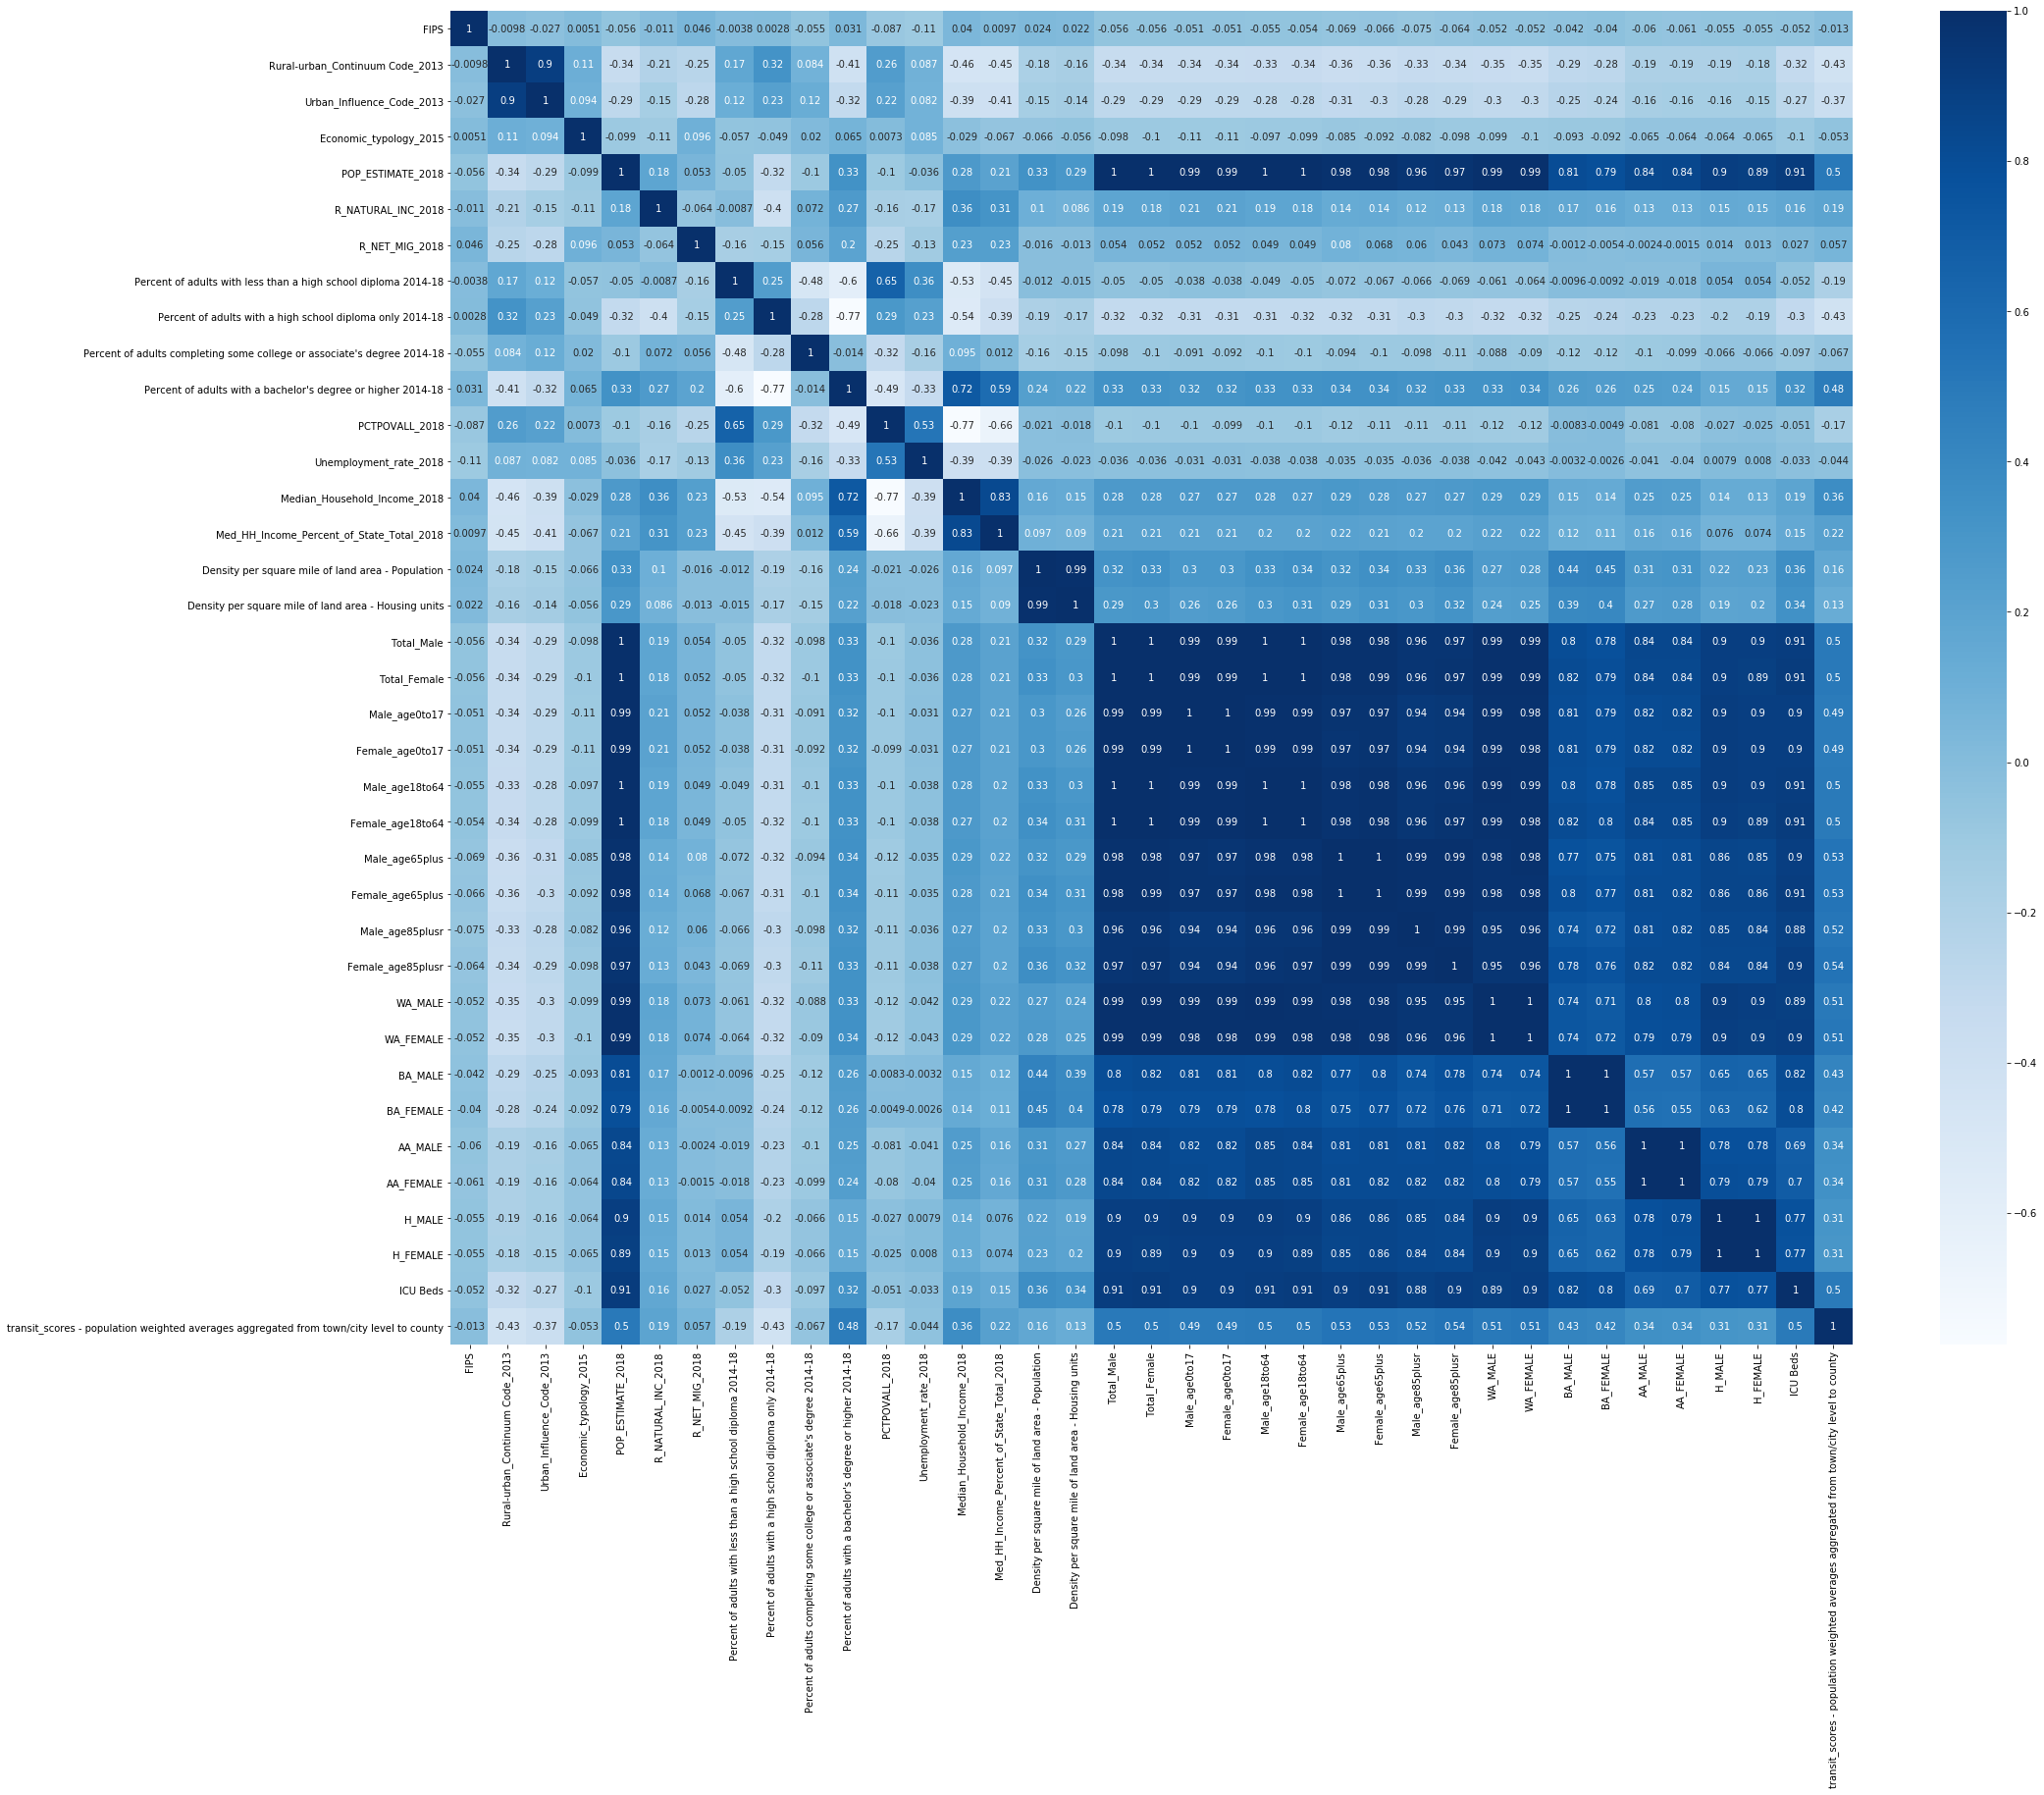

In [80]:
plt.rcParams['figure.figsize'] = [32, 25] # width, height
sns.heatmap(df_soc_econ.corr(), cmap="Blues", annot=True)
plt.show()

Below I am going to clean and format the JHU data to work well with the socioeconomic data in df_soc_econ.  
df_cases_us --> 2912 (JHU)  
df_soc_econ --> 3142 (Cornell)

In [120]:
s = ["Accomack", "Albemarle", "Alexandria"]
for town in list(df_cases_us[df_cases_us.Province_State == "Virginia"].FIPS):
    if town not in list(df_soc_econ[df_soc_econ.State == "VA"].FIPS):
        print(town)

90051.0


90051 is the FIPS code for unassigned
After further examination --> 90001 through 90056 are FIPS Codes for unassigned (not every number in this sequence is used though)

It looks like the johns hopkins data has unassigned states. Below I explore the dataset to try and eliminate inconsistencies with the county data. Obviously, I don't need to do all the investigating below (I can simply drop all NaN FIPS), but I want to understand what the data is.

Federal Correctional Institution (FCI) in JHU with no FIPS
New York City --> bronx is not in JHU, JHU only has NYC: will have to combine 5 boroughs. Or just fill it with another source

In [144]:
# df_soc_econ has all 50 states + DC
states=list()
for item in list(df_soc_econ.State):
    if item not in states:
        states.append(item)
print(len(states))
states

51


['AL',
 'AK',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY']

In [145]:
# df_cases_us has 50 states + DC and ['Diamond Princess', 'Grand Princess', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Recovered', 'Virgin Islands']
states=list()
for item in list(df_cases_us.Province_State):
    if item not in states:
        states.append(item)
states

['South Carolina',
 'Louisiana',
 'Virginia',
 'Idaho',
 'Iowa',
 'Kentucky',
 'Missouri',
 'Oklahoma',
 'Colorado',
 'Illinois',
 'Indiana',
 'Mississippi',
 'Nebraska',
 'Ohio',
 'Pennsylvania',
 'Washington',
 'Wisconsin',
 'Vermont',
 'Minnesota',
 'Florida',
 'North Carolina',
 'California',
 'New York',
 'Wyoming',
 'Michigan',
 'Maryland',
 'Alaska',
 'Kansas',
 'Tennessee',
 'Texas',
 'Maine',
 'Arizona',
 'Georgia',
 'Arkansas',
 'New Jersey',
 'South Dakota',
 'Alabama',
 'West Virginia',
 'North Dakota',
 'Massachusetts',
 'Utah',
 'Montana',
 'New Hampshire',
 'Oregon',
 'New Mexico',
 'Rhode Island',
 'Nevada',
 'District of Columbia',
 'Connecticut',
 'Hawaii',
 'Delaware',
 'Diamond Princess',
 'Grand Princess',
 'Guam',
 'Northern Mariana Islands',
 'Puerto Rico',
 'Recovered',
 'Virgin Islands']

In [146]:
# Remove ['Diamond Princess', 'Grand Princess', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Recovered', 'Virgin Islands']
remove_areas = ['Diamond Princess', 'Grand Princess', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Recovered', 'Virgin Islands']
df_cases_us = df_cases_us[~df_cases_us.Province_State.isin(remove_areas)]
states=list()
for item in list(df_cases_us.Province_State):
    if item not in states:
        states.append(item)
print(len(states))
states

51


['South Carolina',
 'Louisiana',
 'Virginia',
 'Idaho',
 'Iowa',
 'Kentucky',
 'Missouri',
 'Oklahoma',
 'Colorado',
 'Illinois',
 'Indiana',
 'Mississippi',
 'Nebraska',
 'Ohio',
 'Pennsylvania',
 'Washington',
 'Wisconsin',
 'Vermont',
 'Minnesota',
 'Florida',
 'North Carolina',
 'California',
 'New York',
 'Wyoming',
 'Michigan',
 'Maryland',
 'Alaska',
 'Kansas',
 'Tennessee',
 'Texas',
 'Maine',
 'Arizona',
 'Georgia',
 'Arkansas',
 'New Jersey',
 'South Dakota',
 'Alabama',
 'West Virginia',
 'North Dakota',
 'Massachusetts',
 'Utah',
 'Montana',
 'New Hampshire',
 'Oregon',
 'New Mexico',
 'Rhode Island',
 'Nevada',
 'District of Columbia',
 'Connecticut',
 'Hawaii',
 'Delaware']

In [152]:
df_cases_us.shape

(2905, 12)

Clearly there is still a discrepency between the two datasets counties.  
Need to drop FIPS that are nan --> correctional facility

80008	Out of CO  
80013	Out of GA  
80015	Out of HI  
80026	Out of MI  
80040	Out of OK  
80047	Out of TN  

In [395]:
# Below prints all NaN FIPS in JHU data
# If I wanted to, I could come back to this and find closest county to add stats to.
sel = df_cases_us.apply(lambda row: np.isnan(row.FIPS), axis=1)
df_cases_us[sel]

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
142,NaN,Bear River,Utah,US,2020-05-01 02:32:28,41.521068,-113.083282,60,1,0,59,"Bear River, Utah, US"
394,NaN,Central Utah,Utah,US,2020-05-01 02:32:28,39.372319,-111.575868,23,0,0,23,"Central Utah, Utah, US"
745,NaN,Dukes and Nantucket,Massachusetts,US,2020-05-01 02:32:28,41.406747,-70.687635,28,1,0,27,"Dukes and Nantucket, Massachusetts, US"
832,NaN,Federal Correctional Institution (FCI),Michigan,US,2020-05-01 02:32:28,NaN,NaN,88,2,0,86,"Federal Correctional Institution (FCI), Michig..."
1324,NaN,Kansas City,Missouri,US,2020-05-01 02:32:28,39.099700,-94.578600,545,16,0,529,"Kansas City, Missouri, US"
1725,NaN,Michigan Department of Corrections (MDOC),Michigan,US,2020-05-01 02:32:28,NaN,NaN,1453,42,0,1411,"Michigan Department of Corrections (MDOC), Mic..."
2390,NaN,Southeast Utah,Utah,US,2020-05-01 02:32:28,38.996171,-110.701396,12,0,0,12,"Southeast Utah, Utah, US"
2392,NaN,Southwest Utah,Utah,US,2020-05-01 02:32:28,37.854472,-111.441876,98,2,0,96,"Southwest Utah, Utah, US"
2557,NaN,TriCounty,Utah,US,2020-05-01 02:32:28,40.124915,-109.517442,13,0,0,13,"TriCounty, Utah, US"
2781,NaN,Weber-Morgan,Utah,US,2020-05-01 02:32:28,41.271160,-111.914512,158,2,0,156,"Weber-Morgan, Utah, US"


Below I drop columns in df_cases_us_trim. I only care about confirmed and deaths. Also, I rename Admin2 to County and Province_State to State. Also, convert fips to integers

In [445]:
df_cases_us = df_cases_us.loc[:, ["FIPS", "Admin2", "Province_State", "Confirmed", "Deaths"]]
df_cases_us.rename(columns={"Admin2": "County", "Province_State": "State"}, inplace=True)
# df_cases_us.FIPS = df_cases_us.FIPS.astype("int32") # Come back to this
df_cases_us.head()

,FIPS,County,State,Confirmed,Deaths
0,45001.0,Abbeville,South Carolina,31,0
1,22001.0,Acadia,Louisiana,130,10
2,51001.0,Accomack,Virginia,264,4
3,16001.0,Ada,Idaho,671,16
4,19001.0,Adair,Iowa,1,0


In [446]:
fips_boro = [36005, 36047, 36061, 36081, 36085] # bronx, kings, manhattan, queens, richmond
county = ["Bronx", "Kings", "New York", "Queens", "Richmond"]
state = 5*["New York"]
confirmed = [37785, 45519, 22175, 52274, 11937]
deaths = [2704, 4153, 1609, 4126, 576]
df_borough = pd.DataFrame({"FIPS":fips_boro, "County": county, "State": state, "Confirmed":confirmed, "Deaths":deaths})
df_cases_us = df_cases_us.append(df_borough)
# Drop the New York City row since it is now redundant --> its index is 
sel = (df_cases_us.County == "New York City")
df_cases_us = df_cases_us[~sel]

In [449]:
FIPS_cases = list(df_cases_us.FIPS)
FIPS_county = list(df_soc_econ.FIPS)

# Get list of FIPS in df_cases_us --> will use this list to drop these fips
drop_list = list()
for i in FIPS_cases:
    if i not in FIPS_county and not math.isnan(i):
        drop_list.append(i)
        
# Drop rows 
sel = ~df_cases_us.FIPS.isin(drop_list)
df_cases_us_trim = df_cases_us[sel]
df_cases_us_trim = df_cases_us_trim.dropna(subset=["FIPS"])
df_cases_us_trim.shape

(2842, 5)

Drop counties with cases below 25. This will solve our problem that df_soco_econ has a couple hundred more observations than df_cases_us.

In [450]:
# Drop counties that have cases below 25
sel = df_cases_us_trim.apply(lambda row: row.Confirmed > 25, axis=1)
sel.value_counts()
df_cases_us_trim = df_cases_us_trim[sel]
# Get fips in df_cases
fips = df_cases_us_trim.FIPS
# Drop counties that are not in fips
df_soc_econ_trim = df_soc_econ[df_soc_econ.FIPS.isin(fips)]
display(df_cases_us_trim.shape)
display(df_soc_econ_trim.shape)

(1362, 5)

(1362, 39)

Great, the number of counties line up. Now, just check and see if all the counties remaining match...  
The below loop prints nothing, so this means all of our counties are the same in both datasets.

In [451]:
for i in list(df_soc_econ_trim.FIPS):
    if i not in list(df_cases_us_trim.FIPS):
        print(i)        

In [452]:
display(df_cases_us_trim.describe())
display(df_cases_us_trim.info())
display(df_soc_econ_trim.info())

,FIPS,Confirmed,Deaths
count,1362.000000,1362.000000,1362.000000
mean,28744.921439,770.886197,41.822320
std,15236.083962,3319.421109,221.050024
min,1001.000000,26.000000,0.000000
25%,17065.500000,48.250000,1.000000
50%,28074.000000,103.500000,4.000000
75%,42006.500000,317.750000,14.000000
max,56039.000000,52274.000000,4153.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 0 to 4
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FIPS       1362 non-null   float64
 1   County     1362 non-null   object 
 2   State      1362 non-null   object 
 3   Confirmed  1362 non-null   int64  
 4   Deaths     1362 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 63.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 2 to 3190
Data columns (total 39 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   FIPS                                                                                     1362 non-null   int32  
 1   State                                                                                    1362 non-null   object 
 2   Area_Name                                                                                1362 non-null   object 
 3   Rural-urban_Continuum Code_2013                                                          1362 non-null   int8   
 4   Urban_Influence_Code_2013                                                                1362 non-null   int8   
 5   Economic_typology_2015                                        

None

The ethnic demographic data is missing for Dona Ana County, NM. I don't want to drop this county since the population estimate is 217,522. So, I will fill with the mean of the data. This will only affect the regression by lowering the standard deviation of these columns. However, looking at neighboring county is easier and probably more close to the ground truth. After a quick search, it looks like Otero county is the most similar bordering county. The wikipedia page has ethnic info, so its strange that this data is missing.

In [454]:
# FIPS for otero county is 35035
otero_row = df_soc_econ[df_soc_econ.FIPS == 35035]
otero_row
cols = ["WA_MALE", "WA_FEMALE", "BA_MALE", "BA_FEMALE", "AA_MALE", "AA_FEMALE", "H_MALE", "H_FEMALE"]
# get totals for otero
total_male_o = float(otero_row.Total_Male)
total_female_o = float(otero_row.Total_Female)
# get totals for Dona Ana
total_male_d = float(df_soc_econ_trim[df_soc_econ_trim.FIPS == 35013].Total_Male)
total_female_d = float(df_soc_econ_trim[df_soc_econ_trim.FIPS == 35013].Total_Female)
totals = list() # will hold estimated total population for each ethnic group
# get percentage makeup of each category in cols
for i, col in enumerate(cols):
    if(i%2 == 0): # male
        totals.append(round(total_male_d*(float(otero_row.loc[:,col])/total_male_o)))
    else: # female
        totals.append(round(total_female_d*(float(otero_row.loc[:,col])/total_female_o)))

# Apply percentages to Dona Ana
df_soc_econ_trim.loc[1835, cols] = totals

Below I investigate the missing transit scores --> I decide just to drop transit score. It's a weird stat anyway.

In [456]:
df_soc_econ_trim.rename(columns={"transit_scores - population weighted averages aggregated from town/city level to county": "transit_score"}, inplace=True)

In [457]:
df_soc_econ_trim[np.isnan(df_soc_econ_trim.transit_score)]

,FIPS,State,Area_Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,...,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,AA_MALE,AA_FEMALE,H_MALE,H_FEMALE,ICU Beds,transit_score
409,13021,GA,Bibb County,3,2,0,153095,2.5,-1.100000,14.300000,...,29962.0,31716.0,38749.0,46258.0,1618.0,1749.0,2750.0,2466.0,117,NaN
1045,21067,KY,Fayette County,2,2,4,323780,5.1,-0.200000,9.100000,...,123165.0,127510.0,24130.0,25330.0,6848.0,6929.0,12988.0,11040.0,260,NaN
1238,24510,MD,Baltimore city,1,1,4,602495,1.7,-13.800000,15.100000,...,94812.0,96498.0,172006.0,206470.0,8004.0,8659.0,17051.0,16010.0,508,NaN
1624,29510,MO,St. Louis city,1,1,0,302838,2.7,-19.200001,13.100000,...,73184.0,71117.0,63729.0,75366.0,5255.0,5397.0,6776.0,5733.0,207,NaN
1864,36005,NY,Bronx County,1,1,0,1432132,6.3,-11.700000,28.000000,...,306074.0,336533.0,290408.0,334392.0,31135.0,33312.0,379958.0,427270.0,270,NaN
1885,36047,NY,Kings County,1,1,0,2582830,8.0,-13.200000,18.400000,...,628594.0,650176.0,391616.0,489680.0,157577.0,169433.0,239230.0,253470.0,318,NaN
1902,36081,NY,Queens County,1,1,0,2278906,5.5,-13.400000,18.500000,...,542870.0,549365.0,216256.0,255651.0,294701.0,316573.0,320679.0,318933.0,129,NaN
1904,36085,NY,Richmond County,1,1,0,476179,2.5,-1.100000,11.500000,...,174638.0,183559.0,25817.0,29887.0,23450.0,25035.0,43831.0,45057.0,114,NaN
2352,44001,RI,Bristol County,1,1,0,48649,-3.9,0.900000,9.900000,...,22075.0,23695.0,394.0,321.0,480.0,608.0,790.0,764.0,0,NaN
2556,47169,TN,Trousdale County,1,1,5,11012,1.5,12.800000,19.799999,...,5512.0,3921.0,874.0,390.0,12.0,37.0,137.0,132.0,0,NaN


In [458]:
df_soc_econ_trim.drop("transit_score", inplace=True, axis=1)
# drop Med_HH_Income_Percent_of_State_Total_2018 since it is highly correlated with Median_Household_Income_2018  

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Below we see that all our socio-economic data is full.

In [460]:
df_soc_econ_trim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 2 to 3190
Data columns (total 38 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   FIPS                                                                     1362 non-null   int32  
 1   State                                                                    1362 non-null   object 
 2   Area_Name                                                                1362 non-null   object 
 3   Rural-urban_Continuum Code_2013                                          1362 non-null   int8   
 4   Urban_Influence_Code_2013                                                1362 non-null   int8   
 5   Economic_typology_2015                                                   1362 non-null   int8   
 6   POP_ESTIMATE_2018                                                       

Now that the cases dataframe has the same counties as the socio-economic dataset, we can now prep the data for our regression models.  

Rural-urban_Continuum Code_2013, Urban_Influence_Code_2013, Economic_typology_2015 are categorical values are categorical, so we will transform them into one-hot encodings. First, we create a seperate dataframe for each categorical variable, and then we merge each one-hot dataframe with df_soc_econ_trim. In order to merge properly, the index of each one-hot dataframe must be the same as the index of df_soc_econ_trim.  

- Ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html  


Economic Typology:
- 0=Nonspecialized 
- 1=farm-dependent
- 2=Mining-dependent
- 3=Manufacturing-dependent
- 4=Federal/State government-dependent
- 5=Recreation county  

Rural-Urban Continuum Code: 9-level classification of counties by metro-nonmetro status, location, and urban size https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/documentation/


Urban Influence Code: 12-level classification of counties by metro-micro-nonmetro status, location, and size of largest place https://www.ers.usda.gov/data-products/urban-influence-codes/


In [554]:
enc = OneHotEncoder(handle_unknown='ignore')

# Rural-urban_Continuum Code_2013 --> range = (1,9)
enc.fit(df_soc_econ_trim.iloc[:,[3]]) 
one_hot_rural = enc.transform(df_soc_econ_trim.iloc[:,[3]]).toarray().astype("int8")
rural_labels = ["Rural-Urban_Continuum_Code = {}".format(i) for i in range(1,10)]
df_rural = pd.DataFrame(one_hot_rural, columns=rural_labels, index=df_soc_econ_trim.index)

# Urban_Influence_Code_2013 --> range = (1,12)
enc.fit(df_soc_econ_trim.iloc[:,[4]]) 
one_hot_urban = enc.transform(df_soc_econ_trim.iloc[:,[4]]).toarray().astype("int8")
urban_labels = ["Urban_Influence_Code = {}".format(i) for i in range(1,13)]
df_urban = pd.DataFrame(one_hot_urban, columns=urban_labels, index=df_soc_econ_trim.index)

# Economic_typology_2015 --> range = (0,5)
enc.fit(df_soc_econ_trim.iloc[:,[5]]) 
one_hot_type = enc.transform(df_soc_econ_trim.iloc[:,[5]]).toarray().astype("int8")
type_labels = ["Economic_Typology = {}".format(i) for i in range(6)]
df_type = pd.DataFrame(one_hot_type, columns=type_labels, index=df_soc_econ_trim.index)

# Merge one-hot dataframes
df_soc_econ_trim = pd.concat([df_soc_econ_trim, df_rural, df_urban, df_type], axis=1, sort=False)

# Drop original categorical columns
df_soc_econ_trim.drop(["Rural-urban_Continuum Code_2013", "Urban_Influence_Code_2013", "Economic_typology_2015"], inplace=True, axis=1)

In [561]:
#df_soc_econ_trim.info()

In [571]:
df_cases_us_trim.FIPS = df_cases_us_trim.FIPS.astype("int32")
df_cases_us_trim.sort_values("FIPS", inplace=True)

Double check that the FIPS match up in both dataframes. Then combine both datasets into one called df_covid.

In [573]:
list(df_cases_us_trim.FIPS) == list(df_soc_econ_trim.FIPS)

True

In [590]:
new_index = list(range(df_soc_econ_trim.shape[0]))
df_cases_us_trim.index = new_index
df_soc_econ_trim.index = new_index
df_covid = pd.concat([df_cases_us_trim, df_soc_econ_trim.iloc[:,3:]], axis=1, sort=False)
df_covid.head()

,FIPS,County,State,Confirmed,Deaths,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,...,Urban_Code = 9,Urban_Code = 10,Urban_Code = 11,Urban_Code = 12,Economic_Typology = 0,Economic_Typology = 1,Economic_Typology = 2,Economic_Typology = 3,Economic_Typology = 4,Economic_Typology = 5
0,1001,Autauga,Alabama,44,4,55601,2.2,0.600000,11.300000,32.599998,...,0,0,0,0,1,0,0,0,0,0
1,1003,Baldwin,Alabama,174,3,218022,0.1,24.799999,9.700000,27.600000,...,0,0,0,0,0,0,0,0,0,1
2,1005,Barbour,Alabama,39,1,24881,-2.5,-8.600000,27.000000,35.700001,...,0,0,0,0,0,0,0,1,0,0
3,1007,Bibb,Alabama,42,0,22400,-0.3,-6.600000,16.799999,47.299999,...,0,0,0,0,1,0,0,0,0,0
4,1009,Blount,Alabama,37,0,57840,0.3,0.000000,19.799999,34.000000,...,0,0,0,0,1,0,0,0,0,0


In [591]:
display(df_covid.info())
display(df_covid.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 0 to 1361
Data columns (total 64 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   FIPS                                                                     1362 non-null   int32  
 1   County                                                                   1362 non-null   object 
 2   State                                                                    1362 non-null   object 
 3   Confirmed                                                                1362 non-null   int64  
 4   Deaths                                                                   1362 non-null   int64  
 5   POP_ESTIMATE_2018                                                        1362 non-null   int32  
 6   R_NATURAL_INC_2018                                                      

None

,FIPS,Confirmed,Deaths,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,Urban_Code = 9,Urban_Code = 10,Urban_Code = 11,Urban_Code = 12,Economic_Typology = 0,Economic_Typology = 1,Economic_Typology = 2,Economic_Typology = 3,Economic_Typology = 4,Economic_Typology = 5
count,1362.000000,1362.000000,1362.000000,1.362000e+03,1362.00000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,...,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000,1362.000000
mean,28744.921439,770.886197,41.822320,2.154896e+05,1.61094,2.662922,12.994348,31.808298,29.861452,25.334509,...,0.019824,0.005140,0.009545,0.002203,0.532305,0.016153,0.028634,0.171806,0.155653,0.095448
std,15236.083962,3319.421109,221.050024,4.840137e+05,3.61632,10.309507,5.686108,7.519735,4.534851,11.014066,...,0.139446,0.071532,0.097266,0.046898,0.499139,0.126109,0.166838,0.377350,0.362660,0.293940
min,1001.000000,26.000000,0.000000,4.853000e+03,-11.50000,-33.799999,1.200000,5.500000,11.400000,8.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17065.500000,48.250000,1.000000,3.726475e+04,-0.70000,-3.400000,8.900000,26.824999,26.900000,16.700001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28074.000000,103.500000,4.000000,7.971600e+04,1.40000,1.400000,11.900000,32.099998,30.100000,22.799999,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42006.500000,317.750000,14.000000,1.930050e+05,3.70000,7.400000,16.299999,37.299999,32.799999,31.799999,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,56039.000000,52274.000000,4153.000000,1.010552e+07,17.90000,49.599998,35.500000,52.299999,44.900002,78.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Below I do EDA on the one-hot economic variables

| Code               | Description                                                                        |
|--------------------|------------------------------------------------------------------------------------|
| Metro counties:    |                                                                                    |
| 1                  | Counties in metro areas of 1 million population or more                            |
| 2                  | Counties in metro areas of 250,000 to 1 million population                         |
| 3                  | Counties in metro areas of fewer than 250,000 population                           |
| Nonmetro counties: |                                                                                    |
| 4                  | Urban population of 20,000 or more, adjacent to a metro area                       |
| 5                  | Urban population of 20,000 or more, not adjacent to a metro area                   |
| 6                  | Urban population of 2,500 to 19,999, adjacent to a metro area                      |
| 7                  | Urban population of 2,500 to 19,999, not adjacent to a metro area                  |
| 8                  | Completely rural or less than 2,500 urban population, adjacent to a metro area     |
| 9                  | Completely rural or less than 2,500 urban population, not adjacent to a metro area |
| U.S. total         | 3,143                                                                              |

| Code       | Number of counties | 2010 population |
|------------|--------------------|-----------------|
| Metro      | 1,167              | 262,452,132     |
| 1          | 432                | 168,523,961     |
| 2          | 379                | 65,609,956      |
| 3          | 356                | 28,318,215      |
| Nonmetro   | 1,976              | 46,293,406      |
| 4          | 214                | 13,538,322      |
| 5          | 92                 | 4,953,810       |
| 6          | 593                | 14,784,976      |
| 7          | 433                | 8,248,674       |
| 8          | 220                | 2,157,448       |
| 9          | 424                | 2,610,176       |
| U.S. total | 3,143              | 308,745,538     |

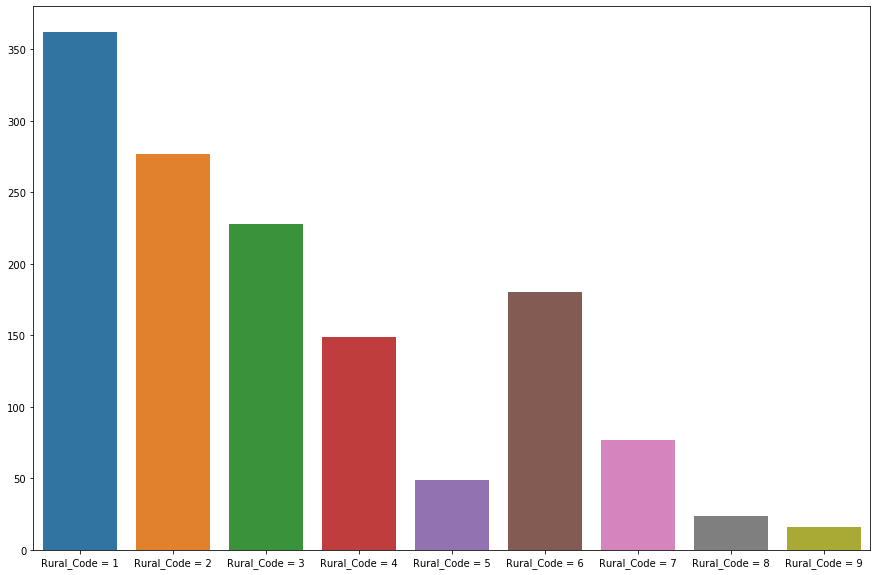

In [628]:
plt.rcParams['figure.figsize'] = [15, 10] # width, height
rural_code_amts = list()
for i in range(37,46): # 37-45
    rural_code_amts.append(df_covid.iloc[:,i].sum())

sns.barplot(x=rural_labels,y=rural_code_amts)

Get percentage of counties per code in df_covid --> percentage is simply (# Counties in df_covid) / (# Counties)

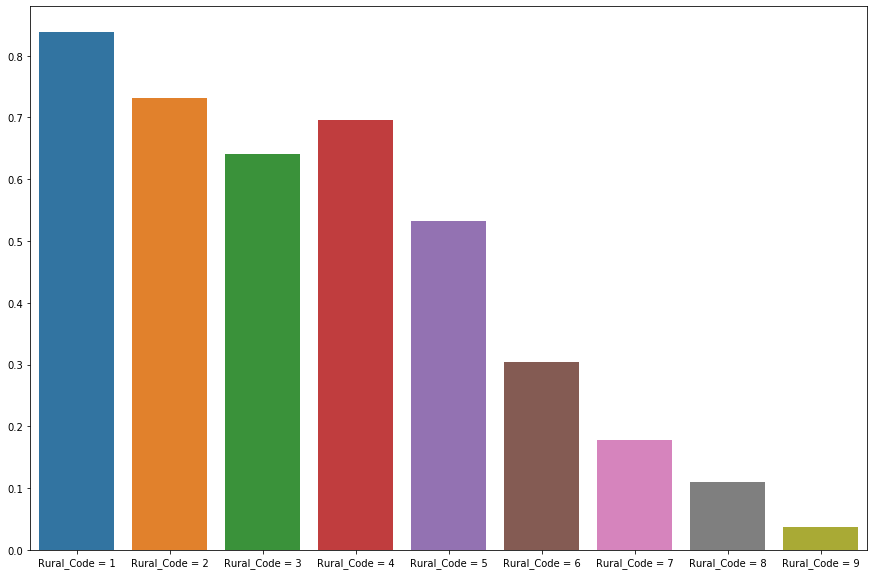

In [636]:
total_counties = [432,379,356,214,92,593,433,220,424]
percentages = list()
for index, num in enumerate(total_counties):
    percentages.append(rural_code_amts[index]/num)
sns.barplot(x=rural_labels,y=percentages)

# BELOW I EXPLORE FEATURE SELECTION

In [650]:
df_covid.iloc[:,5:]

,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,PCTPOVALL_2018,Unemployment_rate_2018,Median_Household_Income_2018,...,Urban_Code = 9,Urban_Code = 10,Urban_Code = 11,Urban_Code = 12,Economic_Typology = 0,Economic_Typology = 1,Economic_Typology = 2,Economic_Typology = 3,Economic_Typology = 4,Economic_Typology = 5
0,55601,2.2,0.600000,11.300000,32.599998,28.400000,27.700001,13.800000,3.6,59338.0,...,0,0,0,0,1,0,0,0,0,0
1,218022,0.1,24.799999,9.700000,27.600000,31.299999,31.299999,9.800000,3.6,57588.0,...,0,0,0,0,0,0,0,0,0,1
2,24881,-2.5,-8.600000,27.000000,35.700001,25.100000,12.200000,30.900000,5.2,34382.0,...,0,0,0,0,0,0,0,1,0,0
3,22400,-0.3,-6.600000,16.799999,47.299999,24.400000,11.500000,21.799999,4.0,46064.0,...,0,0,0,0,1,0,0,0,0,0
4,57840,0.3,0.000000,19.799999,34.000000,33.500000,12.600000,13.200000,3.5,50412.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,171020,2.3,1.500000,7.200000,33.599998,31.900000,27.299999,10.400000,2.7,57785.0,...,0,0,0,0,0,0,0,1,0,0
1358,39531,0.4,-8.000000,8.800000,31.100000,36.599998,23.500000,15.700000,5.2,51204.0,...,0,0,0,0,1,0,0,0,0,0
1359,98976,4.4,0.800000,6.800000,25.799999,38.700001,28.700001,9.100000,3.9,63839.0,...,0,0,0,0,0,0,0,0,1,0
1360,79115,3.2,-8.700000,7.500000,29.000000,40.799999,22.700001,9.900000,4.6,64714.0,...,0,0,0,0,0,0,1,0,0,0


In [657]:
df_covid.iloc[:,8:]

,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,PCTPOVALL_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Density per square mile of land area - Population,Density per square mile of land area - Housing units,...,Urban_Code = 9,Urban_Code = 10,Urban_Code = 11,Urban_Code = 12,Economic_Typology = 0,Economic_Typology = 1,Economic_Typology = 2,Economic_Typology = 3,Economic_Typology = 4,Economic_Typology = 5
0,11.300000,32.599998,28.400000,27.700001,13.800000,3.6,59338.0,119.000000,91.800003,37.200001,...,0,0,0,0,1,0,0,0,0,0
1,9.700000,27.600000,31.299999,31.299999,9.800000,3.6,57588.0,115.500000,114.599998,65.500000,...,0,0,0,0,0,0,0,0,0,1
2,27.000000,35.700001,25.100000,12.200000,30.900000,5.2,34382.0,68.900002,31.000000,13.400000,...,0,0,0,0,0,0,0,1,0,0
3,16.799999,47.299999,24.400000,11.500000,21.799999,4.0,46064.0,92.300003,36.799999,14.400000,...,0,0,0,0,1,0,0,0,0,0
4,19.799999,34.000000,33.500000,12.600000,13.200000,3.5,50412.0,101.099998,88.900002,37.000000,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,7.200000,33.599998,31.900000,27.299999,10.400000,2.7,57785.0,95.099998,384.299988,168.800003,...,0,0,0,0,0,0,0,1,0,0
1358,8.800000,31.100000,36.599998,23.500000,15.700000,5.2,51204.0,82.199997,4.400000,1.900000,...,0,0,0,0,1,0,0,0,0,0
1359,6.800000,25.799999,38.700001,28.700001,9.100000,3.9,63839.0,102.500000,34.200001,15.100000,...,0,0,0,0,0,0,0,0,1,0
1360,7.500000,29.000000,40.799999,22.700001,9.900000,4.6,64714.0,103.900002,14.100000,6.300000,...,0,0,0,0,0,0,1,0,0,0


In [683]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

yuh = SelectKBest(f_regression, k=25).fit(df_covid.iloc[:,5:], df_covid["Deaths"])
df_covid.iloc[:,5:].columns[yuh.get_support()]

Index(['POP_ESTIMATE_2018',
       'Percent of adults completing some college or associate's degree 2014-18',
       'Density per square mile of land area - Population',
       'Density per square mile of land area - Housing units', 'Total_Male',
       'Total_Female', 'Male_age0to17', 'Female_age0to17', 'Male_age18to64',
       'Female_age18to64', 'Male_age65plus', 'Female_age65plus',
       'Male_age85plusr', 'Female_age85plusr', 'WA_MALE', 'WA_FEMALE',
       'BA_MALE', 'BA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'H_MALE', 'H_FEMALE',
       'ICU Beds', 'Rural_Code = 1', 'Urban_Code = 1'],
      dtype='object')


# BELOW I WILL SIMPLY LOOK AT COUNTIES IN BOTH DATA SETS AND RUN A SIMPLE REGRESSION

In [237]:
df_soc_econ_test = df_soc_econ.dropna()

In [238]:
#df_soc_econ
#df_cases_us
FIPS_cases = list(df_cases_us.FIPS)
FIPS_county = list(df_soc_econ_test.FIPS)

#Ref: https://kite.com/python/answers/how-to-find-common-elements-between-two-lists-in-python
FIPS_cases_set = set(FIPS_cases)
fips = list(FIPS_cases_set.intersection(FIPS_county))



In [239]:
# t just stands for test
df_soc_econ_t = df_soc_econ_test[df_soc_econ_test.FIPS.isin(fips)].sort_values("FIPS")
# Prettys sure this is already sorted, but I sort below just to make sure
df_cases_us_t = df_cases_us[df_cases_us.FIPS.isin(fips)].sort_values("FIPS")

In [240]:
# Drop the strings and the econ indicators that need to be one-hot encoded
df_soc_econ_t = df_soc_econ_t.iloc[:,6:]

#### Try out a linear regression below
How do I get p-values?  
How can I use all the data? --> drop the NaN

In [241]:
# Need to limit # of rows since I get error: ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(df_soc_econ_t, df_cases_us_t.Deaths)

In [242]:
reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [243]:
reg.coef_

array([-3.39543865e-04, -5.00895669e-02,  3.91981629e-03, -7.19998220e+01,
       -7.14646734e+01, -7.06681303e+01, -7.40265371e+01,  1.55964820e+00,
       -8.92664167e-01,  1.07681825e-03,  7.55102430e-02, -6.94206455e-01,
        1.76775199e+00, -2.62216025e-03,  2.28276887e-03,  2.50944245e-02,
       -2.10455429e-02, -7.37291148e-03,  3.89723519e-03, -2.03440520e-02,
        1.94307292e-02, -9.74020364e-02,  7.36858760e-02,  8.25947512e-03,
       -6.43765192e-03,  1.04009879e-02, -8.91801495e-03,  1.57335880e-02,
       -1.27262431e-02,  1.13982462e-03, -1.15337977e-03, -6.06115570e-01,
        3.46788809e-09])

In [245]:
reg.score(df_soc_econ_t, df_cases_us_t.Deaths)

0.9157214356519818

In [244]:
df_results = pd.DataFrame({"Variables":df_soc_econ_t.columns, "Coefficients": reg.coef_})
df_results

,Variables,Coefficients
0,POP_ESTIMATE_2018,-3.395439e-04
1,R_NATURAL_INC_2018,-5.008957e-02
2,R_NET_MIG_2018,3.919816e-03
3,Percent of adults with less than a high school...,-7.199982e+01
4,Percent of adults with a high school diploma o...,-7.146467e+01
5,Percent of adults completing some college or a...,-7.066813e+01
6,Percent of adults with a bachelor's degree or ...,-7.402654e+01
7,PCTPOVALL_2018,1.559648e+00
8,Unemployment_rate_2018,-8.926642e-01
9,Median_Household_Income_2018,1.076818e-03


In [263]:
reg = LinearRegression().fit(df_soc_econ_t.iloc[:,6:8], df_cases_us_t.Deaths)
reg.coef_

array([6.328601, 3.751822], dtype=float32)

Try some PCA below